In [14]:
#Import all the libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
import math
import urllib
import difflib 
import seaborn as sns
import sklearn.model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
import os
import random
import tensorflow as tf
from keras import backend as K

In [15]:
'''Loads the dataframe of with the features'''
df_All_Companies_merged = pd.read_pickle(r'Data/all_data_features_s.pkl')
df_All_Companies_merged_brand = pd.read_pickle(r'Data/all_data_features_b.pkl')

In [16]:
temp = df_All_Companies_merged['maximum_founders_university_score'].values[:].tolist()
for idx in range(len(temp)):
    df_All_Companies_merged.at[idx, 'maximum_founders_university_score'] = temp[idx]/100

In [17]:
temp = df_All_Companies_merged['maximum_founders_university_employer_score'].values[:].tolist()
for idx in range(len(temp)):
    df_All_Companies_merged.at[idx, 'maximum_founders_university_employer_score'] = temp[idx]/100

In [18]:
'''
Set the random state for reproducibility of results

'''
def set_random_state():    
    # Seed value
    # Apparently you may use different seed values at each stage
    seed_value= 0

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [73]:
'''
THIS WILL TRAIN A NEURAL NETWORK USING TOP RANKED FEATURES

WE SHALL USE TESTING DATA, VALIDATION DATA, AND SEE THE SUCCESS RATE.
'''


training_params_binary = ['percentage_founders_in_sf', 'in_sf', 'maximum_founders_university_score', 
                          'maximum_founders_university_employer_score', 'c_unicorn_flag','series_b_flag', 'seed_per',
                          'success_flag']

df_for_binary_model_training = df_All_Companies_merged[training_params_binary].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
print('Size of data set is: ', len(df_for_binary_model_training.index))

y = df_for_binary_model_training.pop('success_flag').to_frame()
print('Size of successful companies in set is: ', (np.sum(y.to_numpy())))
X = df_for_binary_model_training

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.3, random_state = 0)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.5, random_state = 0)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()

print('Size train set is {} and number of successful companies in set is {}'.format(len(X_train),np.sum(y_train)) )
print('Size test set is {} and number of successful companies in set is {}'.format(len(X_test),np.sum(y_test)) )
print('Size validation set is {} and number of successful companies in set is {}'.format(len(X_val),np.sum(y_val)) )


number_of_classes = 1
number_of_features = X_train.shape[1]
model = Sequential()
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
set_random_state()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 500, verbose = 0)

eval = model.evaluate(x=X_test, y=y_test)
print('The loss on the test set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 1].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only successful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 0].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only unsuccessful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

Size of data set is:  6482
Size of successful companies in set is:  1913
Size train set is 4537 and number of successful companies in set is 1339
Size test set is 3241 and number of successful companies in set is 957
Size validation set is 3241 and number of successful companies in set is 956
102/102 [==============================] - 0s 2ms/step - loss: 0.3625 - binary_accuracy: 0.8136
The loss on the test set is 0.36253824830055237 and the binary accuracy is 0.8136377930641174
60/60 [==============================] - 0s 2ms/step - loss: 2.1490 - binary_accuracy: 0.4417
The loss on only successful companies set is 2.1490471363067627 and the binary accuracy is 0.4417145848274231
143/143 [==============================] - 0s 1ms/step - loss: 0.4430 - binary_accuracy: 0.8831
The loss on only unsuccessful companies set is 0.44304561614990234 and the binary accuracy is 0.8831254243850708


In [64]:
# Now we see how normalising all features will impact the model

df_nn = pd.read_pickle(r'all_data_features_s.pkl')
df_nn_brand = pd.read_pickle(r'all_data_features_b.pkl')

dropped_columns = ['org_name', 'domain', 'founded_on', 'city', 'category_list', 'category_groups_list', 
                   'short_description', 'universities_of_founders', 'degrees_of_founders', 'subject_degrees_of_founders', 
                   'gender_of_founders', 'city_of_founders', 'prev_companies_of_founders', 'prev_title_of_founders', 
                   'uni_country', 'degrees_of_founders_standardised', 'degrees_of_founders_standardised_numbers', 
                   'number_of_male_founders', 'number_of_female_founders']
df_nn.drop(dropped_columns, axis=1, inplace=True)


# Noramlise columns
df_nn['maximum_founders_university_score'] = df['maximum_founders_university_score']/np.max(df['maximum_founders_university_score'].values)
df_nn['minimum_founders_university_score'] = df['minimum_founders_university_score']/np.max(df['minimum_founders_university_score'].values)
df_nn['average_founders_university_score'] = df['average_founders_university_score']/np.max(df['average_founders_university_score'].values)
df_nn['average_founders_university_employer_score'] = df['average_founders_university_employer_score']/np.max(df['average_founders_university_employer_score'].values)
df_nn['maximum_founders_university_employer_score'] = df['maximum_founders_university_employer_score']/np.max(df['maximum_founders_university_employer_score'].values)
df_nn['num_universities'] = df['num_universities']/np.max(df['num_universities'].values)
df_nn['number_of_founders'] = df['number_of_founders']/np.max(df['number_of_founders'])
df_nn['best_degree_of_founders'] = df['best_degree_of_founders']/np.max(df['best_degree_of_founders'])
df_nn['worse_degree_of_founders'] = df['worse_degree_of_founders']/np.max(df['worse_degree_of_founders'])
df_nn['average_degree_of_founders'] = df['average_degree_of_founders']/np.max(df['average_degree_of_founders'])

# Impute columns with missing data
input_list = ['maximum_founders_university_score',
              'average_founders_university_score',
              'maximum_founders_university_employer_score',
              'average_founders_university_employer_score', 
              'stanford_flag', 
              'stem_flag',
              'IVY_flag', 
              'percentage_founders_in_sf',
              'in_sf',
              'c_unicorn_flag',
              'series_b_flag',
              'series_c_flag',
              'seed_per']
for word in input_list:
    df_nn[word].fillna(df[word].mean(), inplace=True)

#print(df['average_investor_score'].values)

# Display the combined MoneyBall dataframe head
print('Combined Dataframe Shape:', df_nn.shape)
display(HTML(df_nn.head(n=1).to_html()))

Combined Dataframe Shape: (7019, 52)


,success_flag,maximum_founders_university_score,minimum_founders_university_score,average_founders_university_score,average_founders_university_employer_score,maximum_founders_university_employer_score,US_uni_flag,US_uni_percentage,stanford_flag,stanford_percentage,MIT_flag,MIT_percentage,IVY_flag,IVY_percentage,top_int_flag,top_int_percentage,num_universities,number_of_founders,percentage_of_male_founders,in_sf,in_ny,in_miami,percentage_founders_in_sf,percentage_founders_in_ny,percentage_founders_in_miami,best_degree_of_founders,worse_degree_of_founders,average_degree_of_founders,percentage_of_founders_with_a_degree,post_covid_flag,stem_flag,stem_percentage,international_uni_flag,international_uni_percentage,big_flag,big_percentage,unicorn_flag,unicorn_percentage,start_up_flag,c_unicorn_flag,series_a_flag,series_b_flag,series_c_flag,unfunded_flag,seed_flag,start_up_per,c_unicorn_per,series_a_per,series_b_per,series_c_per,unfunded_per,seed_per
0,1,0.599,0.2,0.2934,0.1278,0.3,1.0,0.016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294118,0.294118,1.0,0.0,1.0,0.0,0.0,0.6,0.4,0.5,0.25,0.3,1.0,0.0,1.0,0.4,1.0,0.6,0.0,0.0,1.0,0.1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.5,0.1,0.15,0.0,0.1,0.05,0.3


In [67]:
'''
THIS WILL TRAIN A NEURAL NETWORK USING standardised features 


WE SHALL USE TESTING DATA, VALIDATION DATA, AND SEE THE SUCCESS RATE.
'''

# All main numerical features
university_features = ['maximum_founders_university_score',
                     'average_founders_university_score',
                     'maximum_founders_university_employer_score',
                     'average_founders_university_employer_score', 
                     'stanford_flag', 
                     'stem_flag',
                     'IVY_flag']

company_features = ['percentage_founders_in_sf',
                    'in_sf',
                    'c_unicorn_flag',
                    'series_b_flag',
                    'series_c_flag',
                    'seed_per']
training_params_binary = university_features+company_features+['success_flag']

df_for_binary_model_training = df_nn[training_params_binary].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
print('Size of data set is: ', len(df_for_binary_model_training.index))

y = df_for_binary_model_training.pop('success_flag').to_frame()
print('Size of successful companies in set is: ', (np.sum(y.to_numpy())))
X = df_for_binary_model_training

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.3, random_state = 0)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.5, random_state = 0)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()

print('Size train set is {} and number of successful companies in set is {}'.format(len(X_train),np.sum(y_train)) )
print('Size test set is {} and number of successful companies in set is {}'.format(len(X_test),np.sum(y_test)) )
print('Size validation set is {} and number of successful companies in set is {}'.format(len(X_val),np.sum(y_val)) )


number_of_classes = 1
number_of_features = X_train.shape[1]
model = Sequential()
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
set_random_state()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 500, verbose = 0)

eval = model.evaluate(x=X_test, y=y_test)
print('The loss on the test set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 1].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only successful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 0].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only unsuccessful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

Size of data set is:  7019
Size of successful companies in set is:  2030
Size train set is 4913 and number of successful companies in set is 1421
Size test set is 3509 and number of successful companies in set is 1015
Size validation set is 3510 and number of successful companies in set is 1015
110/110 [==============================] - 0s 1ms/step - loss: 0.2083 - binary_accuracy: 0.8817
The loss on the test set is 0.20830391347408295 and the binary accuracy is 0.881732702255249
58/58 [==============================] - 0s 1ms/step - loss: 1682.9922 - binary_accuracy: 0.4888
The loss on only successful companies set is 1682.9921875 and the binary accuracy is 0.4888039231300354
136/136 [==============================] - 0s 1ms/step - loss: 309.6280 - binary_accuracy: 0.4856
The loss on only unsuccessful companies set is 309.6279602050781 and the binary accuracy is 0.48560240864753723


In [68]:
'''
THIS WILL TRAIN A NEURAL NETWORK USING standardised inputs and ONLY university inputs


WE SHALL USE TESTING DATA, VALIDATION DATA, AND SEE THE SUCCESS RATE.
'''

# All main numerical features
training_params_binary = ['maximum_founders_university_score',
                     'average_founders_university_score',
                     'maximum_founders_university_employer_score',
                     'average_founders_university_employer_score', 
                     'stanford_flag', 
                     'stem_flag',
                     'IVY_flag','success_flag']


df_for_binary_model_training = df_nn[training_params_binary].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
print('Size of data set is: ', len(df_for_binary_model_training.index))

y = df_for_binary_model_training.pop('success_flag').to_frame()
print('Size of successful companies in set is: ', (np.sum(y.to_numpy())))
X = df_for_binary_model_training

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.3, random_state = 0)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.5, random_state = 0)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()

print('Size train set is {} and number of successful companies in set is {}'.format(len(X_train),np.sum(y_train)) )
print('Size test set is {} and number of successful companies in set is {}'.format(len(X_test),np.sum(y_test)) )
print('Size validation set is {} and number of successful companies in set is {}'.format(len(X_val),np.sum(y_val)) )


number_of_classes = 1
number_of_features = X_train.shape[1]
model = Sequential()
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
set_random_state()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 500, verbose = 0)

eval = model.evaluate(x=X_test, y=y_test)
print('The loss on the test set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 1].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only successful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 0].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only unsuccessful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

Size of data set is:  7019
Size of successful companies in set is:  2030
Size train set is 4913 and number of successful companies in set is 1421
Size test set is 3509 and number of successful companies in set is 1015
Size validation set is 3510 and number of successful companies in set is 1015
110/110 [==============================] - 0s 1ms/step - loss: 0.5034 - binary_accuracy: 0.7435
The loss on the test set is 0.5034039616584778 and the binary accuracy is 0.7435166835784912
61/61 [==============================] - 0s 1ms/step - loss: 545.5505 - binary_accuracy: 0.0382
The loss on only successful companies set is 545.550537109375 and the binary accuracy is 0.03816400095820427
148/148 [==============================] - 0s 1ms/step - loss: 5.4896 - binary_accuracy: 0.9619
The loss on only unsuccessful companies set is 5.4896440505981445 and the binary accuracy is 0.9619370102882385


In [74]:
'''
THIS WILL TRAIN A NEURAL NETWORK USING standardised ONLY company inputs

WE SHALL USE TESTING DATA, VALIDATION DATA, AND SEE THE SUCCESS RATE.
'''

# All main numerical features
 

training_params_binary = ['percentage_founders_in_sf',
                    'in_sf',
                    'c_unicorn_flag',
                    'series_b_flag',
                    'series_c_flag',
                    'seed_per','success_flag']

df_for_binary_model_training = df_nn[training_params_binary].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
print('Size of data set is: ', len(df_for_binary_model_training.index))

y = df_for_binary_model_training.pop('success_flag').to_frame()
print('Size of successful companies in set is: ', (np.sum(y.to_numpy())))
X = df_for_binary_model_training

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.3, random_state = 0)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X, y,stratify=y, test_size=0.5, random_state = 0)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()

print('Size train set is {} and number of successful companies in set is {}'.format(len(X_train),np.sum(y_train)) )
print('Size test set is {} and number of successful companies in set is {}'.format(len(X_test),np.sum(y_test)) )
print('Size validation set is {} and number of successful companies in set is {}'.format(len(X_val),np.sum(y_val)) )


number_of_classes = 1
number_of_features = X_train.shape[1]
model = Sequential()
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(2**7, input_dim=number_of_features, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
set_random_state()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 500, verbose = 0)

eval = model.evaluate(x=X_test, y=y_test)
print('The loss on the test set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 1].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only successful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

df_for_binary_model_training = df_All_Companies_merged[training_params_binary][df_All_Companies_merged['success_flag'] == 0].copy()
df_for_binary_model_training = df_for_binary_model_training.dropna()
y = df_for_binary_model_training.pop('success_flag').to_frame()
X = df_for_binary_model_training

eval = model.evaluate(x=X.to_numpy(), y=y.to_numpy())
print('The loss on only unsuccessful companies set is {} and the binary accuracy is {}'.format(eval[0],eval[1]))

Size of data set is:  7019
Size of successful companies in set is:  2030
Size train set is 4913 and number of successful companies in set is 1421
Size test set is 3509 and number of successful companies in set is 1015
Size validation set is 3510 and number of successful companies in set is 1015
110/110 [==============================] - 0s 1ms/step - loss: 0.5015 - binary_accuracy: 0.7538
The loss on the test set is 0.5015251636505127 and the binary accuracy is 0.7537760138511658
60/60 [==============================] - 0s 1ms/step - loss: 1.2572 - binary_accuracy: 0.2457
The loss on only successful companies set is 1.2572276592254639 and the binary accuracy is 0.24568739533424377
143/143 [==============================] - 0s 1ms/step - loss: 0.3696 - binary_accuracy: 0.9286
The loss on only unsuccessful companies set is 0.3695681691169739 and the binary accuracy is 0.9286496043205261


In [19]:
#Import all the libraries needed for SVC and GBC 
import datetime, json, scipy, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5] 
warnings.filterwarnings('ignore')

In [37]:
# load files

df = pd.read_pickle(r'Data/all_data_features_s.pkl')
df_brand = pd.read_pickle(r'Data/all_data_features_b.pkl')

dropped_columns = ['org_name', 'domain', 'founded_on', 'city', 'category_list', 'category_groups_list', 
                   'short_description', 'universities_of_founders', 'degrees_of_founders', 'subject_degrees_of_founders', 
                   'gender_of_founders', 'city_of_founders', 'prev_companies_of_founders', 'prev_title_of_founders', 
                   'uni_country', 'degrees_of_founders_standardised', 'degrees_of_founders_standardised_numbers', 
                   'number_of_male_founders', 'number_of_female_founders']
df.drop(dropped_columns, axis=1, inplace=True)


# Noramlize columns
df['maximum_founders_university_score'] = df['maximum_founders_university_score']/np.max(df['maximum_founders_university_score'].values)
df['minimum_founders_university_score'] = df['minimum_founders_university_score']/np.max(df['minimum_founders_university_score'].values)
df['average_founders_university_score'] = df['average_founders_university_score']/np.max(df['average_founders_university_score'].values)
df['average_founders_university_employer_score'] = df['average_founders_university_employer_score']/np.max(df['average_founders_university_employer_score'].values)
df['maximum_founders_university_employer_score'] = df['maximum_founders_university_employer_score']/np.max(df['maximum_founders_university_employer_score'].values)
df['num_universities'] = df['num_universities']/np.max(df['num_universities'].values)
df['number_of_founders'] = df['number_of_founders']/np.max(df['number_of_founders'])
df['best_degree_of_founders'] = df['best_degree_of_founders']/np.max(df['best_degree_of_founders'])
df['worse_degree_of_founders'] = df['worse_degree_of_founders']/np.max(df['worse_degree_of_founders'])
df['average_degree_of_founders'] = df['average_degree_of_founders']/np.max(df['average_degree_of_founders'])

# Impute columns with missing data
df["success_flag"].fillna(0, inplace=True)

input_list = ['maximum_founders_university_score',
              'average_founders_university_score',
              'maximum_founders_university_employer_score',
              'average_founders_university_employer_score', 
              'stanford_flag', 
              'stem_flag',
              'IVY_flag', 
              'percentage_founders_in_sf',
              'in_sf',
              'c_unicorn_flag',
              'series_b_flag',
              'series_c_flag',
              'seed_per']
for word in input_list:
    df[word].fillna(df[word].mean(), inplace=True)

# Display the combined dataframe head
print('Combined Dataframe Shape:', df.shape)
display(HTML(df.head(n=1).to_html()))

Combined Dataframe Shape: (7019, 52)


,success_flag,maximum_founders_university_score,minimum_founders_university_score,average_founders_university_score,average_founders_university_employer_score,maximum_founders_university_employer_score,US_uni_flag,US_uni_percentage,stanford_flag,stanford_percentage,MIT_flag,MIT_percentage,IVY_flag,IVY_percentage,top_int_flag,top_int_percentage,num_universities,number_of_founders,percentage_of_male_founders,in_sf,in_ny,in_miami,percentage_founders_in_sf,percentage_founders_in_ny,percentage_founders_in_miami,best_degree_of_founders,worse_degree_of_founders,average_degree_of_founders,percentage_of_founders_with_a_degree,post_covid_flag,stem_flag,stem_percentage,international_uni_flag,international_uni_percentage,big_flag,big_percentage,unicorn_flag,unicorn_percentage,start_up_flag,c_unicorn_flag,series_a_flag,series_b_flag,series_c_flag,unfunded_flag,seed_flag,start_up_per,c_unicorn_per,series_a_per,series_b_per,series_c_per,unfunded_per,seed_per
0,1,0.599,0.2,0.2934,0.1278,0.3,1.0,0.016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294118,0.294118,1.0,0.0,1.0,0.0,0.0,0.6,0.4,0.5,0.25,0.3,1.0,0.0,1.0,0.4,1.0,0.6,0.0,0.0,1.0,0.1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.5,0.1,0.15,0.0,0.1,0.05,0.3


In [21]:
test_size = 0.3

# All main numerical features
university_features = ['maximum_founders_university_score',
                     'average_founders_university_score',
                     'maximum_founders_university_employer_score',
                     'average_founders_university_employer_score', 
                     'stanford_flag', 
                     'stem_flag',
                     'IVY_flag',]

company_features = ['percentage_founders_in_sf',
                    'in_sf',
                    'c_unicorn_flag',
                    'series_b_flag',
                    'series_c_flag',
                    'seed_per']

combined_features = university_features+company_features

X, y = df.loc[:, df.columns!='success_flag'], df['success_flag']
X_university = X[university_features].values
X_company = X[company_features].values
X_combined = X[combined_features].values

y = y.values


print('Features Shape:', X.shape)
print('Labels Shape:', y.shape, '\n')

print('(All) Successful Fraction:', np.sum(y)/y.size)
print('(Training) Successful Fraction:', np.sum(y_train)/y_train.size)
print('(Test) Successful Fraction:', np.sum(y_test)/y_test.size, '\n')

Features Shape: (7019, 51)
Labels Shape: (7019,) 

(All) Successful Fraction: 0.2892149878900128
(Training) Successful Fraction: 0.28923264807653165
(Test) Successful Fraction: 0.28917378917378916 



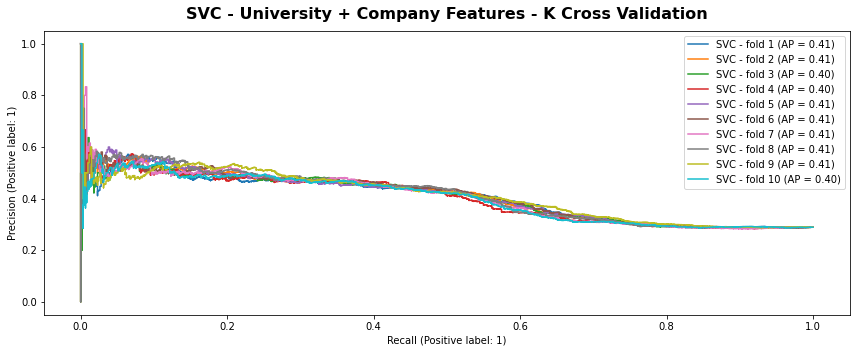

In [29]:
# SVC Model - for both university and company features

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=test_size)

# Hyperparameters
SVC_params = {} #{'C': 0.1}

# Define the final model
SVC_model = SVC(**SVC_params)

# Number of Splits
num_splits = 10

# K-fold validation
cv = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True)
tprs, aucs = [], []

# Plot results
fig = plt.figure()
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    SVC_model.fit(X_train[train], y_train[train])
    plot_precision_recall_curve(SVC_model, X_test, y_test, ax = plt.gca(), name="SVC - fold "+str(i+1))
plt.legend(loc='upper right')
plt.title('SVC - University + Company Features - K Cross Validation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

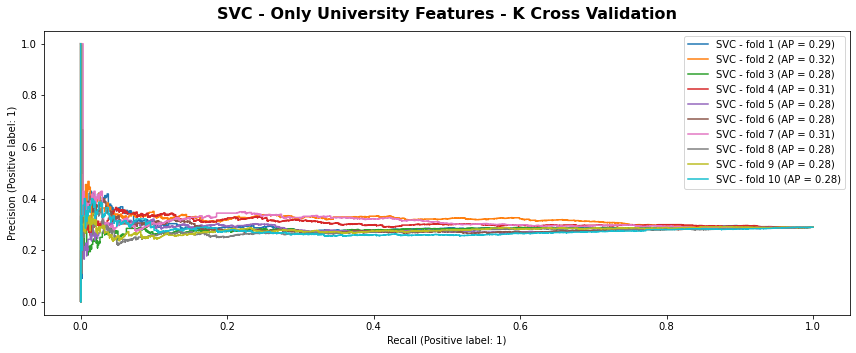

In [38]:
# SVC Model - for both university features

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_university, y, stratify=y, test_size=test_size)

           
# Define the final model
SVC_model = SVC(**SVC_params)

# Number of Splits
num_splits = 10

# K-fold validation
cv = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True)
tprs, aucs = [], []

# Plot results
fig = plt.figure()
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    SVC_model.fit(X_train[train], y_train[train])
    plot_precision_recall_curve(SVC_model, X_test, y_test, ax = plt.gca(), name="SVC - fold "+str(i+1))
plt.legend(loc='upper right')
plt.title('SVC - Only University Features - K Cross Validation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

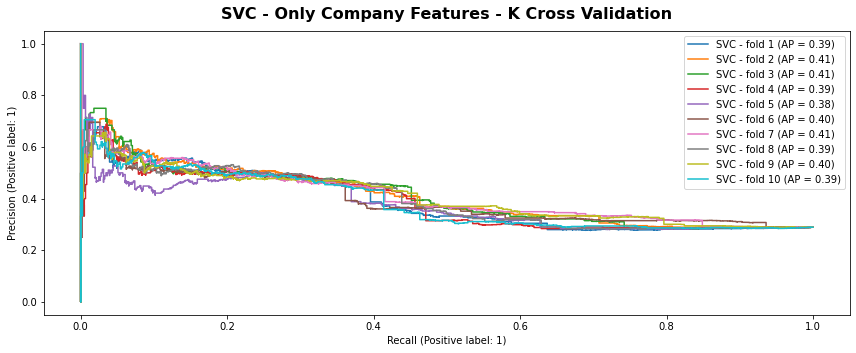

In [39]:
# SVC Model - for company features

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_company, y, stratify=y, test_size=test_size)

           
# Define the final model
SVC_model = SVC(**SVC_params)

# Number of Splits
num_splits = 10

# K-fold validation
cv = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True)
tprs, aucs = [], []

# Plot results
fig = plt.figure()
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    SVC_model.fit(X_train[train], y_train[train])
    plot_precision_recall_curve(SVC_model, X_test, y_test, ax = plt.gca(), name="SVC - fold "+str(i+1))
plt.legend(loc='upper right')
plt.title('SVC - Only Company Features - K Cross Validation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

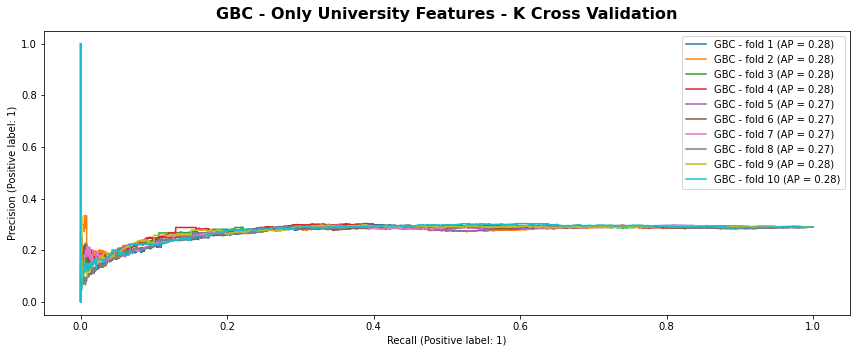

In [40]:
# Gradient Boosting Classifier (GBC)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_university, y, stratify=y, test_size=test_size)

# Hyperparameters
GBC_params = {'loss': 'deviance',
              'n_estimators': 30,
              'learning_rate': 0.1,
              'subsample': 1,
              'max_depth': 10}

# Define the final model
GBC_model = GradientBoostingClassifier(**GBC_params)

# Number of Splits
num_splits = 10

# K-fold validation
cv = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True)
tprs, aucs = [], []

# Plot results
fig = plt.figure()
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    GBC_model.fit(X_train[train], y_train[train])
    plot_precision_recall_curve(GBC_model, X_test, y_test, ax = plt.gca(), name="GBC - fold "+str(i+1))
plt.title('GBC - Only University Features - K Cross Validation', fontsize=16, fontweight='bold', y=1.02)
plt.legend(loc='upper right')
plt.tight_layout()

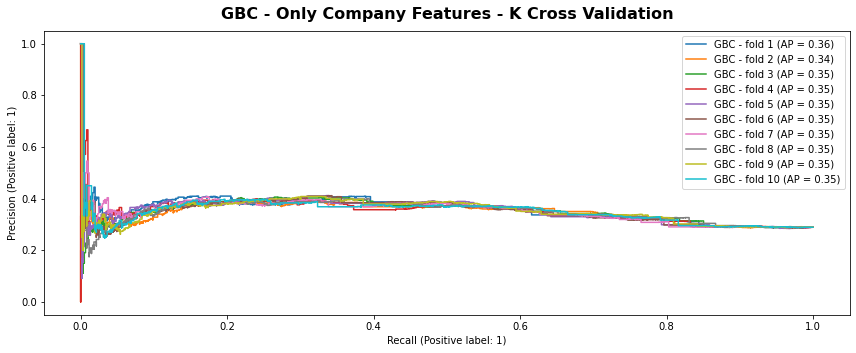

In [41]:
# GBC Model - for company features


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_company, y, stratify=y, test_size=test_size)

# Define the final model
GBC_model = GradientBoostingClassifier(**GBC_params)

# Number of Splits
num_splits = 10

# K-fold validation
cv = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True)
tprs, aucs = [], []

# Plot results
fig = plt.figure()
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    GBC_model.fit(X_train[train], y_train[train])
    plot_precision_recall_curve(GBC_model, X_test, y_test, ax = plt.gca(), name="GBC - fold "+str(i+1))
plt.title('GBC - Only Company Features - K Cross Validation', fontsize=16, fontweight='bold', y=1.02)
plt.legend(loc='upper right')
plt.tight_layout()

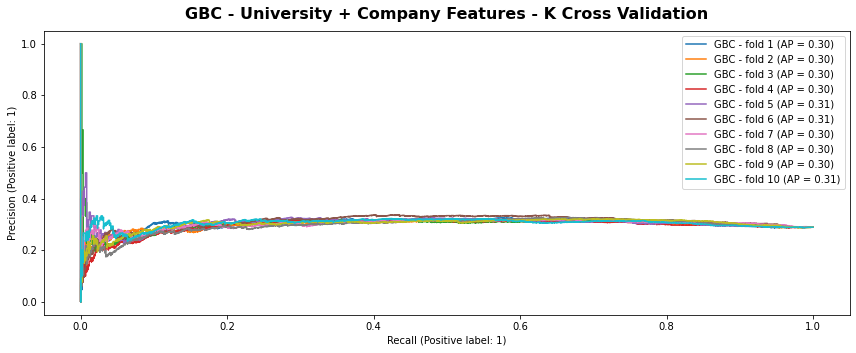

In [42]:
# GBC Model - for universitiy features

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=test_size)

# Define the final model
GBC_model = GradientBoostingClassifier(**GBC_params)

# Number of Splits
num_splits = 10

# K-fold validation
cv = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True)
tprs, aucs = [], []

# Plot results
fig = plt.figure()
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    GBC_model.fit(X_train[train], y_train[train])
    plot_precision_recall_curve(GBC_model, X_test, y_test, ax = plt.gca(), name="GBC - fold "+str(i+1))
plt.title('GBC - University + Company Features - K Cross Validation', fontsize=16, fontweight='bold', y=1.02)

plt.legend(loc='upper right')
plt.tight_layout()

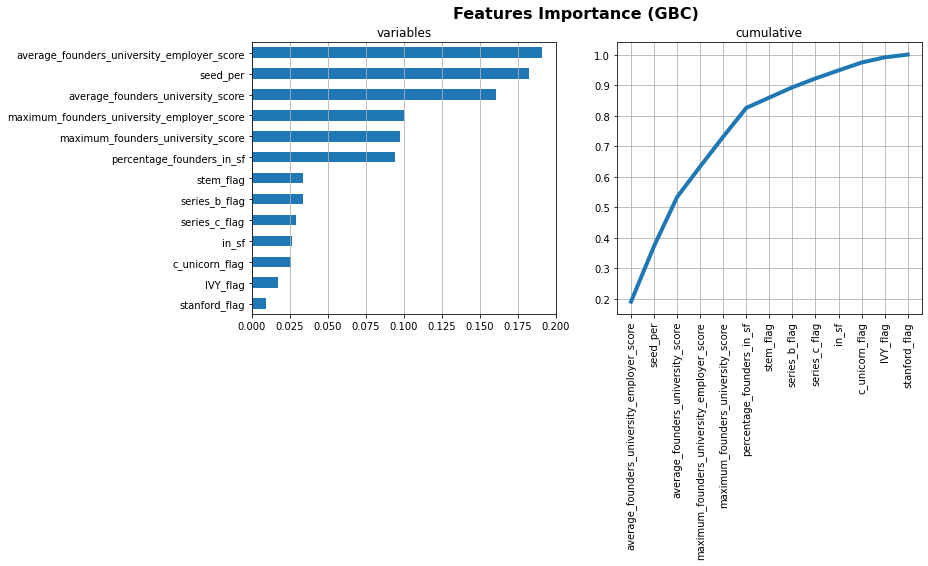

In [43]:
importances = GBC_model.feature_importances_

# Add to a df
df_importances = pd.DataFrame({'IMPORTANCE':importances, 'VARIABLE':combined_features}).sort_values('IMPORTANCE', ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index('VARIABLE')

# Plot the results
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance (GBC)", fontsize=16, fontweight='bold')
ax[0].title.set_text('variables')
df_importances[['IMPORTANCE']].sort_values(by='IMPORTANCE').plot(kind='barh', legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel='')
ax[1].title.set_text('cumulative')
df_importances[['cumsum']].plot(kind='line', linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), xticklabels=df_importances.index)
plt.xticks(rotation=90)
plt.grid(axis='both')

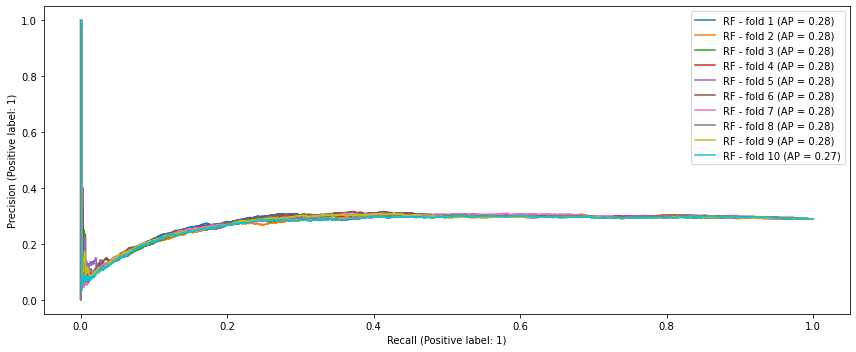

In [53]:
#Random Forest

# Hyperparameters
GBC_params = {'loss': 'deviance',
              'n_estimators': 50,
              'learning_rate': 0.4,
              'subsample': 1}
RF_params = {'n_estimators': 100,
             'max_features': 'auto',
             'max_depth': 100,
             'class_weight': 'balanced'}

# Define the final model
RF_model = RandomForestClassifier(**RF_params)

# Number of Splits
num_splits = 10

# K-fold validation
cv = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True)
tprs, aucs = [], []

# Plot results
fig = plt.figure()
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    RF_model.fit(X_train[train], y_train[train])
    plot_precision_recall_curve(RF_model, X_test, y_test, ax = plt.gca(), name="RF - fold "+str(i+1))
plt.legend(loc='upper right')
plt.tight_layout()